In [1]:
#Importing necessary libraries
import keras
import numpy as np
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
#Loading the dataset directly from Keras' library; normalizing and reshaping it
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train = (x_train.reshape(-1, 28, 28, 1)) / np.max(x_train)
x_test = (x_test.reshape(-1, 28, 28, 1)) / np.max(x_test)
np.max(x_train), np.max(x_test)
#Splitting the dataset into training and validation sets
train_set, val_set, train_out, val_out = train_test_split(x_train, x_train, test_size=0.2, random_state=42)

4423680/4422102 [==============================] - 2s 0us/step


In [3]:
#Declaring model architecture
autoencoder = Sequential()

input_shape=(28, 28, 1)
filters=[32, 64, 128, 10]

if input_shape[0] % 8 == 0:
  pad3 = 'same'
else:
  pad3 = 'valid'

autoencoder.add(Conv2D(filters[0], 5, strides=2, padding='same', activation='relu', name='conv1', input_shape=(28,28,1))) #28 x 28 x 32
autoencoder.add(BatchNormalization())
autoencoder.add(Conv2D(filters[1], 5, strides=2, padding='same', activation='relu', name='conv2'))
autoencoder.add(BatchNormalization())

autoencoder.add(Conv2D(filters[2], 3, strides=2, padding=pad3, activation='relu', name='conv3')) #14 x 14 x 64
autoencoder.add(BatchNormalization())
autoencoder.add(Flatten())

autoencoder.add(Dense(units=filters[3], name='embedding'))

autoencoder.add(Dense(units=filters[2]*int(input_shape[0]/8)*int(input_shape[0]/8), activation='relu'))

autoencoder.add(Reshape((int(input_shape[0]/8), int(input_shape[0]/8), filters[2])))
autoencoder.add(BatchNormalization())
autoencoder.add(Conv2DTranspose(filters[1], 3, strides=2, padding=pad3, activation='relu', name='deconv3'))
autoencoder.add(BatchNormalization())
autoencoder.add(Conv2DTranspose(filters[0], 5, strides=2, padding='same', activation='relu', name='deconv2'))
autoencoder.add(BatchNormalization())

autoencoder.add(Conv2DTranspose(input_shape[2], 5, strides=2, padding='same', name='deconv1'))

In [0]:
#Declaring constants
batch_size = 32
epochs = 100
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))
num_classes = 10

In [5]:
#Compiling the model and settings loss function and optimizer
autoencoder.compile(loss='mean_squared_error', optimizer = Adam())

In [0]:
#Fitting the training data and validating the model
autoencoder_train = autoencoder.fit(train_set, train_out, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(val_set, val_out))

In [6]:
#Printing the summary of model
autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 14, 14, 32)        832       
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
conv2 (Conv2D)               (None, 7, 7, 64)          51264     
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
conv3 (Conv2D)               (None, 3, 3, 128)         73856     
_________________________________________________________________
batch_normalization_3 (Batch (None, 3, 3, 128)         512       
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)             

In [0]:
#Saving the model weights
autoencoder.save_weights('autoencoder_weights.h5')

#Loading the model weights
# autoencoder.load_weights('autoencoder_weights.h5')

In [0]:
#Plotting training & validation loss vs number of epochs while training for auto-encoder
import matplotlib.pyplot as plt
plt.plot(autoencoder.history.history['loss'], color='#009358', marker='o')
plt.plot(autoencoder.history.history['val_loss'], color='orange', marker='o')
plt.title("Training & validation loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(['Training loss', 'Validation loss'])
graph = plt.gcf()
plt.show()
graph.savefig('Task2_3_epoch_loss.png', dpi=300)

In [0]:
#Importing additional libraries required
from sklearn.mixture import GaussianMixture
from sklearn import metrics

In [0]:
#Separating the encoder layer and using the condensed representation
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('embedding').output)

In [12]:
#Declaring, fitting and predicting the clusters for the test dataset
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=10, covariance_type='full', tol=0.01, verbose=1, n_init=10, init_params='kmeans', random_state=42 )
encoder_pred = encoder.predict(x_test).reshape(x_test.shape[0], -1)
y_pred_gmm = gmm.fit_predict(encoder_pred)

Initialization 0
Initialization converged: True
Initialization 1
  Iteration 10
Initialization converged: True
Initialization 2
  Iteration 10
Initialization converged: True
Initialization 3
  Iteration 10
Initialization converged: True
Initialization 4
  Iteration 10
Initialization converged: True
Initialization 5
  Iteration 10
Initialization converged: True
Initialization 6
  Iteration 10
Initialization converged: True
Initialization 7
  Iteration 10
Initialization converged: True
Initialization 8
  Iteration 10
Initialization converged: True
Initialization 9
Initialization converged: True


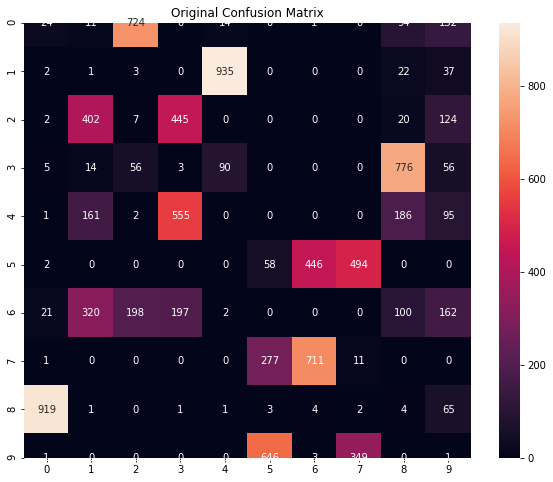

In [13]:
#Observing the confusion matrix
#It can be observed that the clusters are not correctly aligned w.r.t the labels
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

confusionmatrix = confusion_matrix(y_test, y_pred_gmm)
df_cm = pd.DataFrame(confusionmatrix, index = [i for i in "0123456789"], columns = [i for i in "0123456789"])
plt.figure(figsize = (10, 8))
plt.title('Original Confusion Matrix')
cm_original = plt.gcf()
fig = sns.heatmap(df_cm, annot=True, fmt='g')
cm_original.savefig('original_cm_gmm.png', dpi=300)

In [14]:
#Using Hungarian algorithm to compute reordered confusion matrix
from sklearn.utils.linear_assignment_ import linear_assignment
import numpy as np

def _make_cost_m(cm):
    max_value = np.max(cm)
    return (- cm + max_value)

cm = confusion_matrix(y_test, y_pred_gmm)
indices = linear_assignment(_make_cost_m(cm))
number = [element[1] for element in sorted(indices, key=lambda x: x[0])]
reordered_cm = cm[:, number]

print("Accuracy of GMM with auto-encoder: ", (np.trace(reordered_cm) / np.sum(reordered_cm))*100, "%")

Accuracy of GMM with auto-encoder:  63.239999999999995 %


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


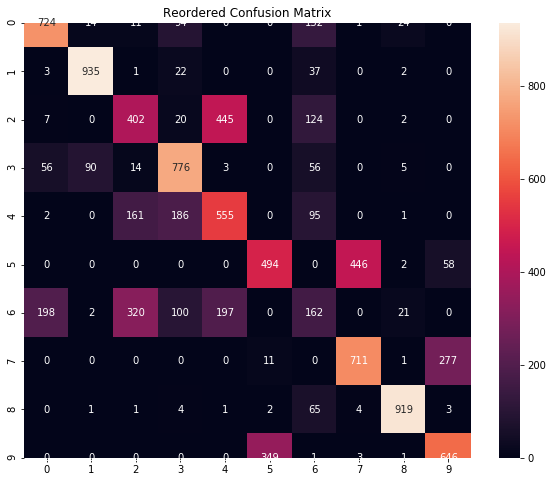

In [15]:
#Visualizing reordered confusion matrix

import seaborn as sns

df_cm = pd.DataFrame(reordered_cm, index = [i for i in "0123456789"], columns = [i for i in "0123456789"])
plt.figure(figsize = (10, 8))
plt.title('Reordered Confusion Matrix')
cm_reordered = plt.gcf()
fig = sns.heatmap(df_cm, annot=True, fmt='g')
# fig.pivot('Predicted labels', 'True labels')
cm_reordered.savefig('reordered_cm_gmm.png', dpi=300)